In [1]:
from read_data import get_synth_data
import matplotlib.pyplot as plt
import numpy as np

from layers.dense import *
import tensorflow as tf
from quantilelosses import *

2023-12-11 10:38:21.977940: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2023-12-11 10:38:21.977975: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
quantiles = [0.05, 0.95]
x_train, y_train, y_train_q = get_synth_data("Expo", x_min=-4,x_max= 4, n=5000, train=True, quantiles=quantiles)
x_test, y_test, y_test_q = get_synth_data("Expo", x_min=-7, x_max= 7, n=5000, train=True, quantiles=quantiles)

2023-12-11 10:38:24.319093: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-11 10:38:24.319122: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (man-tm-aibeast): /proc/driver/nvidia/version does not exist
2023-12-11 10:38:24.320242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# define model with evidential output
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    #DenseNormalGamma(len(quantiles)),
    FaithDenseNormalGamma(len(quantiles)),
])

In [4]:
# Custom loss function to handle custom regularization
def loss(y, output):
    loss = 0.0
    mu, v, alpha, beta = tf.split(output, 4, axis=-1)
    for i, q in enumerate(quantiles):
        #loss += quant_evi_loss(y, tf.expand_dims(mu[:,i], 1), tf.expand_dims(v[:,i],1),
        #                            tf.expand_dims(alpha[:,i],1), tf.expand_dims(beta[:,i],1), q, 
        #                            coeff=3e-1)
        loss += quant_evi_loss_upt(y, tf.expand_dims(mu[:,i], 1), tf.expand_dims(v[:,i],1),
                                    tf.expand_dims(alpha[:,i],1), tf.expand_dims(beta[:,i],1), q, 
                                    coeff=3e-1) 
    return loss

In [5]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-3), 
                loss=loss)
model.fit(x_train, y_train, batch_size=64, epochs=500)

Epoch 1/500
79/79 [==============================] - 3s 2ms/step - loss: 29.5886
Epoch 2/500
79/79 [==============================] - 0s 3ms/step - loss: 16.1666
Epoch 3/500
79/79 [==============================] - 0s 3ms/step - loss: 15.0760
Epoch 4/500
79/79 [==============================] - 0s 2ms/step - loss: 14.2770
Epoch 5/500
79/79 [==============================] - 0s 2ms/step - loss: 14.0383
Epoch 6/500
79/79 [==============================] - 0s 2ms/step - loss: 14.1585
Epoch 7/500
79/79 [==============================] - 0s 2ms/step - loss: 13.9019
Epoch 8/500
79/79 [==============================] - 0s 2ms/step - loss: 13.8259
Epoch 9/500
79/79 [==============================] - 0s 2ms/step - loss: 13.8568
Epoch 10/500
79/79 [==============================] - 0s 2ms/step - loss: 13.7848
Epoch 11/500
79/79 [==============================] - 0s 2ms/step - loss: 13.6140
Epoch 12/500
79/79 [==============================] - 0s 2ms/step - loss: 13.8242
Epoch 13/500
79/79 [=====

In [6]:
preds = model(x_test)
gamma, v, alpha, beta = tf.split(preds, 4, axis=-1)

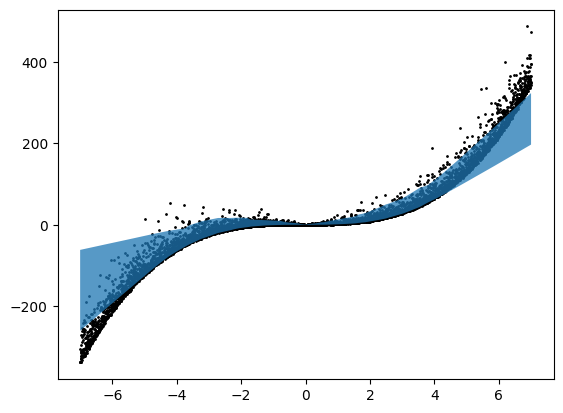

In [7]:
# plot of the quantile regression aleatoric uncertainty
plt.scatter(x_test, y_test, s=1, label='test', c='black')
plt.fill_between(x_test[:,0], gamma[:,0], gamma[:,1], alpha=0.75)

(-400.0, 400.0)

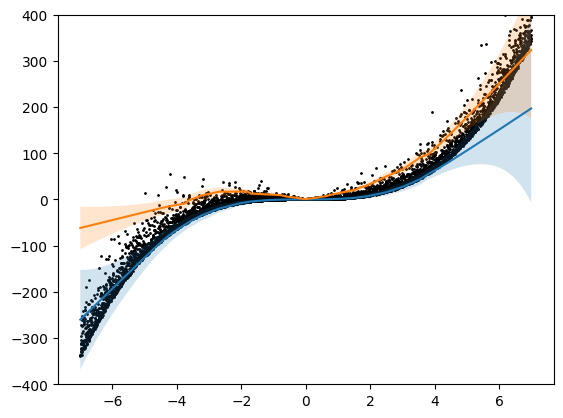

In [8]:
# plot of the quantile regression epistemic uncertainty
var = np.sqrt((beta /(v*(alpha - 1))))
plt.scatter(x_test, y_test, s=1, label='test', c='black')
plt.plot(x_test, gamma[:,0])
plt.plot(x_test, gamma[:,1])
plt.fill_between(x_test[:,0], gamma[:,0]+var[:,0], gamma[:,0]-var[:,0], alpha=0.2)
plt.fill_between(x_test[:,0], gamma[:,1]+var[:,1], gamma[:,1]-var[:,1], alpha=0.2)
plt.ylim(-400, 400)


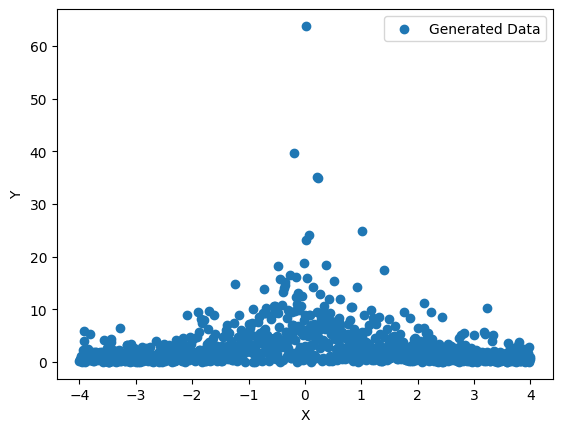

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

x = np.linspace(-4, 4, 1000)

# Generate y values with Gaussian noise (higher around 0, lower away from 0)
noise_strength = np.exp(-0.25 * np.abs(x))
noise = np.random.normal(loc=0, scale= 1.5 * tf.exp(-0.4 * np.abs(x))),#np.random.normal(loc=0, scale= 10 * noise_strength, size=len(x))
#noise = tfd.Exponential(rate=0.1+((0.2*abs(x)))).sample().numpy()
y = noise

# Plot the generated dataset
plt.scatter(x, y, label='Generated Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [5]:
y.shape

AttributeError: 'tuple' object has no attribute 'shape'